# Semantic Segmentation Demo

This notebook how to demonstrates semantic segmentation capabilities using pretrained models:

- SegFormer-B5 (Cityscapes)
- SegFormer-B2 (ADE20K) 
- BEiT-Base (ADE20K)
- DPT-Large (ADE20K)
- UperNet-Swin-Base (ADE20K)
- SMP-SegFormer (Cityscapes)

## Setup and Import

In [ ]:
import sys
import os
import warnings
import time
import torch
from pathlib import Path
from datetime import datetime
from PIL import Image
import matplotlib.pyplot as plt
from IPython.display import clear_output

warnings.filterwarnings('ignore')

# Setup paths
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

# Import styling
try:
    from styles import NotebookStyles, display_style, styles
    print("✅ Styling module loaded successfully")
except ImportError as e:
    print(f"❌ Could not import styles: {e}")

# Import segmentation utilities
try:
    from satellite_segmentation.constants import get_available_models
    from satellite_segmentation.models import load_model, process_image
    from satellite_segmentation.visualization import create_visualization
    print("✅ Segmentation modules loaded successfully")
except ImportError as e:
    print(f"❌ Import error: {e}")

# Display session header
display_style(styles.session_header_2)

## Step 1: Choose and Load a Pre-trained Model

display_style(
    styles.section_header,
    "Model Selection & Loading", 
    "Choose and initialize an AI model for semantic segmentation",
    "🤖"
)

try:
    # Get available models dictionary
    available_models = get_available_models()
    
    # Print available models for manual selection
    print("Available Models:")
    for category, models in available_models.items():
        print(f"\n{category}:")
        for model_name in models.keys():
            print(f"  - {model_name}")
            
    # Manual selection - Change these values to try different models
    selected_category = "SegFormer Models"  # Choose from available categories
    selected_model = "segformer-b2-ade"  # Choose from models in category
    
    # Get model configuration
    model_config = available_models[selected_category][selected_model]
    
    # Load model
    print(f"\nLoading {model_config['description']}...")
    model = load_model(model_config)
    
    # Display model info card
    model_info = {
        'name': model_config['description'],
        'architecture': model_config['type'],
        'dataset': model_config['dataset'],
        'resolution': model_config['model_name'].split('-')[-2],
        'parameters': '84.7M' if 'b5' in model_config['model_name'] else '64.1M'
    }
    
    display_style(styles.segmentation_model_card, model_info)
    print("\n✅ Model loaded successfully!")
    
except Exception as e:
    display_style(
        styles.error_card,
        "Error Loading Model",
        str(e)
    )

## Step 2: Image Processing

In [56]:
display_style(
    styles.section_header,
    "Image Processing", 
    "Load and prepare images for segmentation",
    "🖼️"
)

# Configuration
image_path = '../data/test_3.png'  # Change this to your image path

# Display image preview
display_style(styles.image_preview, image_path, "Input Image")

if os.path.exists(image_path):
    progress_bar = styles.progress_bar(0, "Processing image...")
    display(progress_bar)
    
    try:
        start_time = time.time()
        
        # Get model configuration
        model_config = available_models[selected_category][selected_model]
        
        # If model is a tuple, extract the actual model
        if isinstance(model, tuple):
            actual_model = model[0]
        else:
            actual_model = model
        
        # Load the processor for transformers models
        if model_config['type'] == 'transformers':
            from transformers import SegformerImageProcessor
            processor = SegformerImageProcessor.from_pretrained(model_config['model_name'])
        else:
            processor = None
        
        # Load and preprocess the image
        from PIL import Image
        image = Image.open(image_path).convert('RGB')
        
        # Process image with correct parameter order: (image, model, processor, device, model_type)
        segmentation_output = process_image(
            image,
            actual_model,
            processor,
            'cuda' if torch.cuda.is_available() else 'cpu',
            model_config['type']
        )
        
        processing_time = time.time() - start_time
        
        clear_output(wait=True)
        
        # Re-display image preview
        display_style(styles.image_preview, image_path, "Processed Image")
        
        # Handle tuple output for metrics
        if isinstance(segmentation_output, tuple):
            if len(segmentation_output) >= 1:
                main_output = segmentation_output[0]
                if hasattr(main_output, 'get'):
                    result_dict = main_output
                else:
                    result_dict = {'iou': 0.0, 'pixel_accuracy': 0.0}
            else:
                result_dict = {'iou': 0.0, 'pixel_accuracy': 0.0}
        else:
            result_dict = segmentation_output if segmentation_output else {}
        
        # Display metrics
        metrics = {
            'time': processing_time,
            'iou': result_dict.get('iou', 0.0),
            'accuracy': result_dict.get('pixel_accuracy', 0.0)
        }
        display_style(styles.segmentation_results_card, metrics)
        
    except Exception as e:
        clear_output(wait=True)
        display_style(
            styles.error_card,
            "Processing Error",
            str(e)
        )
else:
    display_style(
        styles.error_card,
        "File Not Found",
        f"Image file not found: {image_path}"
    )

## Step 3: Visualize The Result

Original image size: (1536, 1488)
Original image mode: RGBA
Segmentation map shape: (1488, 1536)
Converted original image to RGB
Found 6 classes: [ 1  3  5  8 12 92]
Original array shape: (1488, 1536, 3)
Color mask shape: (1488, 1536, 3)


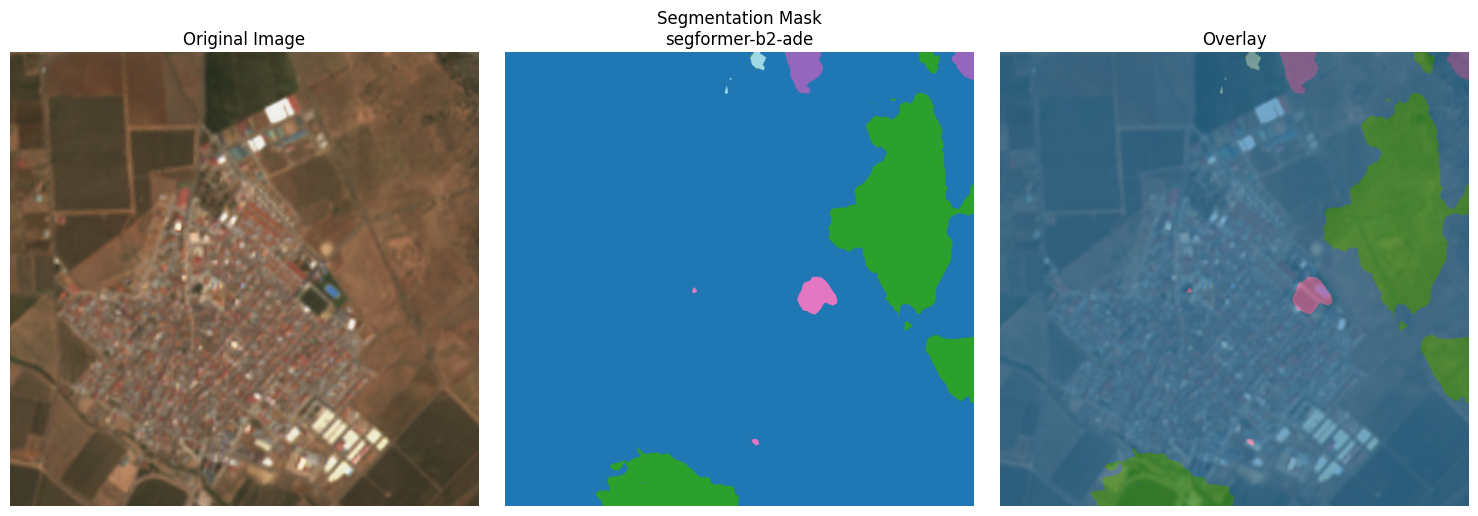

In [57]:
display_style(
    styles.section_header,
    "Segmentation Visualization", 
    "Visual analysis of segmentation results",
    "📊"
)

if 'segmentation_output' in locals():
    try:
        # Handle tuple output - extract segmentation map
        if isinstance(segmentation_output, tuple):
            # Assume first element contains the segmentation data
            seg_data = segmentation_output[0]
            
            # Check if it's a dictionary with segmentation_map
            if hasattr(seg_data, 'get'):
                segmentation_map = seg_data.get('segmentation_map', seg_data)
            else:
                # Assume the data itself is the segmentation map
                segmentation_map = seg_data
        else:
            # Handle dictionary output
            segmentation_map = segmentation_output.get('segmentation_map', segmentation_output)
        
        # Load original image
        original_image = Image.open(image_path)
        print(f"Original image size: {original_image.size}")  # (width, height)
        print(f"Original image mode: {original_image.mode}")
        print(f"Segmentation map shape: {segmentation_map.shape}")  # (height, width)
        
        # Ensure original image is RGB
        if original_image.mode != 'RGB':
            original_image = original_image.convert('RGB')
            print("Converted original image to RGB")
        
        # Resize segmentation map to match original image
        target_height = original_image.size[1]  # height
        target_width = original_image.size[0]   # width
        
        if segmentation_map.shape != (target_height, target_width):
            import cv2
            print(f"Resizing from {segmentation_map.shape} to ({target_height}, {target_width})")
            segmentation_map_resized = cv2.resize(
                segmentation_map, 
                (target_width, target_height),  # (width, height) for cv2
                interpolation=cv2.INTER_NEAREST
            )
            print(f"After resize: {segmentation_map_resized.shape}")
        else:
            segmentation_map_resized = segmentation_map
        
        # Create our own visualization to avoid the problematic function
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        
        # Original image
        axes[0].imshow(original_image)
        axes[0].set_title("Original Image")
        axes[0].axis("off")
        
        # Segmentation mask with colors
        # Create a simple color palette
        unique_labels = np.unique(segmentation_map_resized)
        num_classes = len(unique_labels)
        print(f"Found {num_classes} classes: {unique_labels}")
        
        # Create color mask
        import matplotlib.pyplot as plt
        import matplotlib.colors as mcolors
        
        # Use matplotlib's tab20 colormap for up to 20 classes
        if num_classes <= 20:
            colors = plt.cm.tab20(np.linspace(0, 1, num_classes))
        else:
            colors = plt.cm.tab20(np.linspace(0, 1, 20))  # Fallback
            
        color_mask = np.zeros((*segmentation_map_resized.shape, 3), dtype=np.uint8)
        for i, label in enumerate(unique_labels[:20]):  # Limit to 20 classes
            color_idx = i % len(colors)
            color_mask[segmentation_map_resized == label] = (colors[color_idx][:3] * 255).astype(np.uint8)
        
        axes[1].imshow(color_mask)
        axes[1].set_title(f"Segmentation Mask\n{selected_model}")
        axes[1].axis("off")
        
        # Overlay - manual implementation
        original_array = np.array(original_image)
        print(f"Original array shape: {original_array.shape}")
        print(f"Color mask shape: {color_mask.shape}")
        
        # Ensure shapes match exactly
        if original_array.shape != color_mask.shape:
            print("Shape mismatch in overlay creation")
            axes[2].imshow(original_array)
            axes[2].set_title("Overlay (Original - Shape Mismatch)")
        else:
            # Create overlay by blending arrays directly
            alpha = 0.6
            overlay_array = original_array.astype(np.float32) * (1 - alpha) + color_mask.astype(np.float32) * alpha
            overlay_array = np.clip(overlay_array, 0, 255).astype(np.uint8)
            
            axes[2].imshow(overlay_array)
            axes[2].set_title("Overlay")
        
        axes[2].axis("off")
        
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        display_style(
            styles.error_card,
            "Visualization Error",
            str(e)
        )
        print(f"Full error details: {str(e)}")
        import traceback
        traceback.print_exc()
else:
    display_style(
        styles.error_card,
        "No Results",
        "Run the image processing cell first to generate segmentation results"
    )

## Step 4: Class Distribution
The classes will be different based on the choosed model

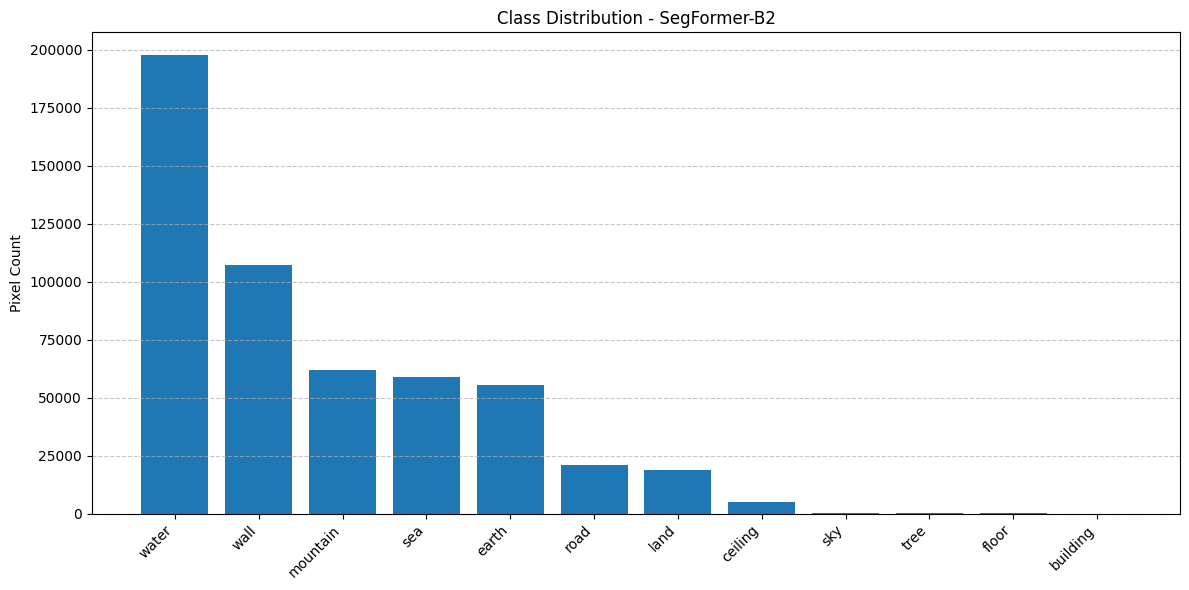

In [55]:
from transformers import AutoConfig

display_style(
    styles.section_header,
    "Class Distribution", 
    "Analysis of detected segments",
    "📈"
)

try:
    if 'segmentation_output' in locals():
        # Get the segmentation mask
        if isinstance(segmentation_output, tuple):
            mask = segmentation_output[0]
        else:
            mask = segmentation_output

        if mask is None:
            display_style(
                styles.warning_card,
                "No Segmentation Data",
                "Mask not found in the current session."
            )
        else:
            # Load labels from model config (auto-load)
            config = AutoConfig.from_pretrained(model_config['model_name'])
            id2label = config.id2label

            # Compute distribution
            unique_labels, counts = np.unique(mask, return_counts=True)

            # Map IDs to human-readable labels
            class_names = [id2label.get(int(i), f"Class {i}") for i in unique_labels]

            # Sort by pixel count
            sorted_pairs = sorted(zip(class_names, counts), key=lambda x: x[1], reverse=True)
            sorted_classes, sorted_counts = zip(*sorted_pairs)

            # Plot
            plt.figure(figsize=(12, 6))
            plt.bar(sorted_classes, sorted_counts)
            plt.title(f"Class Distribution - {model_config['description']}")
            plt.xticks(rotation=45, ha='right')
            plt.ylabel("Pixel Count")
            plt.grid(axis='y', linestyle='--', alpha=0.7)
            plt.tight_layout()
            plt.show()

    else:
        display_style(
            styles.warning_card,
            "No Segmentation Data",
            "Mask not found in the current session."
        )

except Exception as e:
    display_style(
        styles.error_card,
        "Distribution Analysis Error",
        str(e)
    )